## Joint embedding of 10x and SS2 pbmc using scVI

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from fingerprint import SingleCellFingerprintBase
from commons import decode
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

In [2]:
rsem_pbmc_ss2_path = '/home/jupyter/data/ss2/RSEM.TPM.SM2.pbmc1.txt'
pbmc_hvg_gene_indices_path = '/home/jupyter/CellBender/proto/chimera/notebooks/pbmc4k_hvg.npy'
pbmc_hvg_gene_indices_ref_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_only_expressing_sc_fingerprint.pkl'
pbmc_10x_fingerprint_paths = [
    '/home/jupyter/data/10x/pbmc4k_only_expressing_sc_fingerprint.pkl',
    '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_only_expressing_sc_fingerprint.pkl',
    '/home/jupyter/data/10x/pbmc4k_ss_rate_0.125_sc_fingerprint.pkl']
pbmc_10x_batch_names = [
    'pbmc4k_10x_original',
    'pbmc4k_10x_ss_rate_0.25',
    'pbmc4k_10x_ss_rate_0.125']

In [4]:
# load gene names
ref_fp = SingleCellFingerprintBase.load(pbmc_hvg_gene_indices_ref_fingerprint_path)
master_gene_names = np.asarray(ref_fp.gene_names_list)

In [6]:
# make sure that the genes are present in all datasets
expression_mask = np.ones((len(master_gene_names),), dtype=np.bool)
for pbmc_10x_fingerprint_path in pbmc_10x_fingerprint_paths:
    fp = SingleCellFingerprintBase.load(pbmc_10x_fingerprint_path).filter_genes(
        max_good_turing=1.,
        min_total_gene_expression=1.)
    c_expression_mask = np.asarray([gene_name in fp.gene_names_list for gene_name in master_gene_names])
    expression_mask = expression_mask & c_expression_mask

Calculating and caching "SingleCellFingerprintBase.good_turing_estimator_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Number of genes failed the maximum Good-Turing criterion: 0
Number of genes failed the minimum expression criterion: 0
Number of genes failed both criteria: 0
Number of retained genes: 19822
Calculating and caching "SingleCellFingerprintBase.good_turing_estimator_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Number of genes failed the maximum Good-Turing criterion: 0
Number of genes failed the minimum expression criterion: 0
Number of genes failed both criteria: 0
Number of retained genes: 18646
Calculating and caching "SingleCellFingerprintBase.good_turing_estimator_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Number of genes failed the maximum Good-Turing criterion: 15842
Number of genes failed the minimum expression criterion: 15842
Number o

In [8]:
# load pbmc ss2 data
tpms_list = []
ss2_gene_names_list = []
with open(rsem_pbmc_ss2_path, 'r') as f:
    ss2_cell_names = f.readline().strip().split('\t')
    for line in f:
        toks = line.strip().split('\t')
        gene_name = toks[0]
        tpms = [float(x) for x in toks[1:]]
        ss2_gene_names_list.append(gene_name[16:])
        tpms_list.append(tpms)
pbmc_ss2_tpm_array = np.asarray(tpms_list).T

In [9]:
# make sure that genes are also expressed in ss2 data
master_gene_indices_in_ss2 = [ss2_gene_names_list.index(gene_name) for gene_name in master_gene_names]
ss2_expression_mask = pbmc_ss2_tpm_array[:, master_gene_indices_in_ss2].sum(0) > 0

In [10]:
# final master names list
final_master_gene_names = master_gene_names[expression_mask & ss2_expression_mask]

In [13]:
# load pbmc4k data, subset to final_master_gene_names
pbmc_10x_counts_array_list = []
pbmc_10x_barcodes_list = []
for idx, pbmc_10x_fingerprint_path in enumerate(pbmc_10x_fingerprint_paths):
    fp = SingleCellFingerprintBase.load(pbmc_10x_fingerprint_path)
    gene_indices = [fp.gene_names_list.index(gene_name) for gene_name in final_master_gene_names]
    pbmc_10x_counts_array = np.asarray(fp.sparse_count_matrix_csr[:, gene_indices].todense())
    pbmc_10x_counts_array_list.append(pbmc_10x_counts_array)
    suffix = "-" + str(idx)
    pbmc_10x_barcodes_list.append(
        [decode(barcode, 16) + suffix for barcode in fp.barcode_list])

Calculating and caching "SingleCellFingerprintBase.sparse_count_matrix_csr"...
Calculating and caching "SingleCellFingerprintBase.sparse_count_matrix_csr"...
Calculating and caching "SingleCellFingerprintBase.sparse_count_matrix_csr"...


In [63]:
# subset ss2 data onto final_master_gene_names
final_master_gene_indices_in_ss2 = [ss2_gene_names_list.index(gene_name) for gene_name in final_master_gene_names]
pbmc_ss2_tpm_array_final = pbmc_ss2_tpm_array[:, final_master_gene_indices_in_ss2]

In [64]:
# heuristic harmonization ss2 to 10x
ref_10x_count_array = pbmc_10x_counts_array_list[0]
median_total_counts_10x = np.mean(ref_10x_count_array.sum(-1))
ss2_final_counts = median_total_counts_10x

In [65]:
gene_scale_10x = (ref_10x_count_array / ref_10x_count_array.sum(-1)[:, None]).sum(0)
gene_scale_ss2 = (pbmc_ss2_tpm_array_final / pbmc_ss2_tpm_array_final.sum(-1)[:, None]).sum(0)
ss2_to_10x_gene_scale_factor = gene_scale_10x / gene_scale_ss2

In [66]:
pbmc_ss2_frac = pbmc_ss2_tpm_array_final / pbmc_ss2_tpm_array_final.sum(-1)[:, None]
pbmc_ss2_10x_harmonized = ss2_final_counts * pbmc_ss2_frac * ss2_to_10x_gene_scale_factor

In [159]:
# add 10x
sc_data_array_list = [
    pbmc_10x_counts_array
    for pbmc_10x_counts_array in pbmc_10x_counts_array_list]
# sc_data_array_list.append(pbmc_ss2_10x_harmonized)

# batch names
sc_data_batch_names = [
    batch_name_10x for batch_name_10x in pbmc_10x_batch_names]
# sc_data_batch_names.append('pbmc376_ss2')

# var names
sc_data_obs_names = []
for pbmc_10x_barcodes in pbmc_10x_barcodes_list:
    sc_data_obs_names.append(pbmc_10x_barcodes)
# sc_data_obs_names.append(ss2_cell_names)

In [160]:
import pandas as pd
adatas = []
for idx in range(len(sc_data_array_list)):
    adata = anndata.AnnData(sc_data_array_list[idx])
    adata.var_names = anndata.utils.make_index_unique(pd.Index(final_master_gene_names))
    adata.var['gene_ids'] = final_master_gene_names
    adata.obs_names = pd.Index(sc_data_obs_names[idx], name=0)
    adatas.append(adata)

In [161]:
# concatenate them into one adata object
adata = anndata.AnnData.concatenate(*adatas, batch_key='batch')

In [162]:
adata

AnnData object with n_obs × n_vars = 13683 × 16022 
    obs: 'batch'
    var: 'gene_ids'

In [163]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

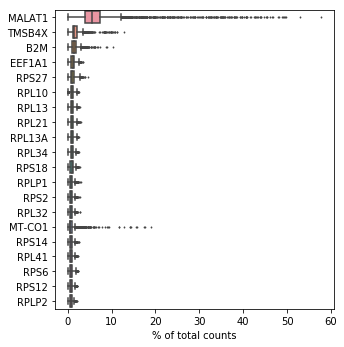

In [164]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [165]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [166]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'gene_ids' as categorical


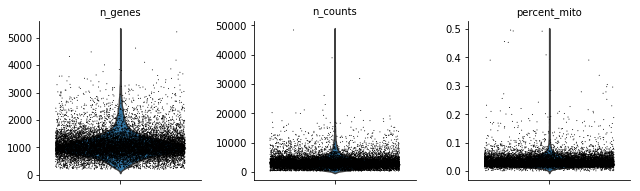

In [167]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

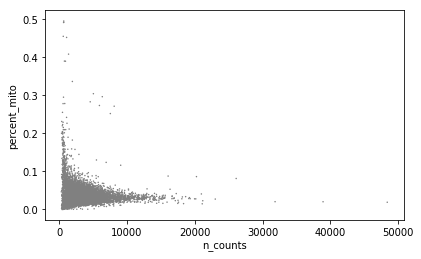

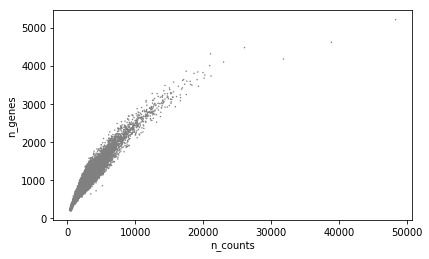

In [168]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [169]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [170]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, making a copy.


In [171]:
sc.pp.log1p(adata)

In [172]:
adata.raw = adata

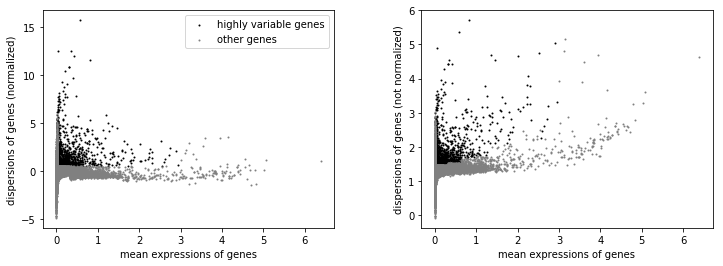

In [173]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

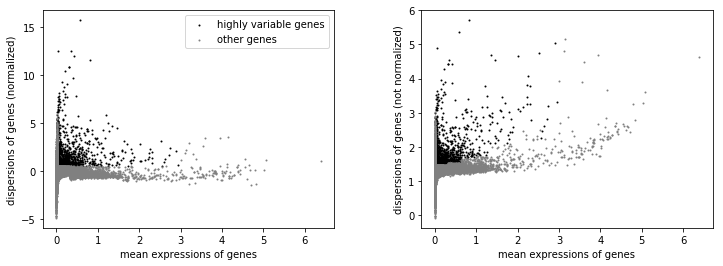

In [174]:
sc.pl.highly_variable_genes(adata)

In [175]:
adata = adata[:, adata.var['highly_variable']]

In [176]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [177]:
sc.pp.scale(adata, max_value=10)

In [178]:
adata

AnnData object with n_obs × n_vars = 11546 × 1795 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [179]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

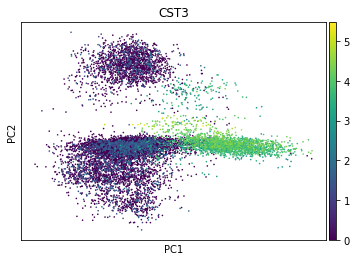

In [180]:
sc.pl.pca(adata, color='CST3')

In [185]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

In [186]:
sc.tl.umap(adata)

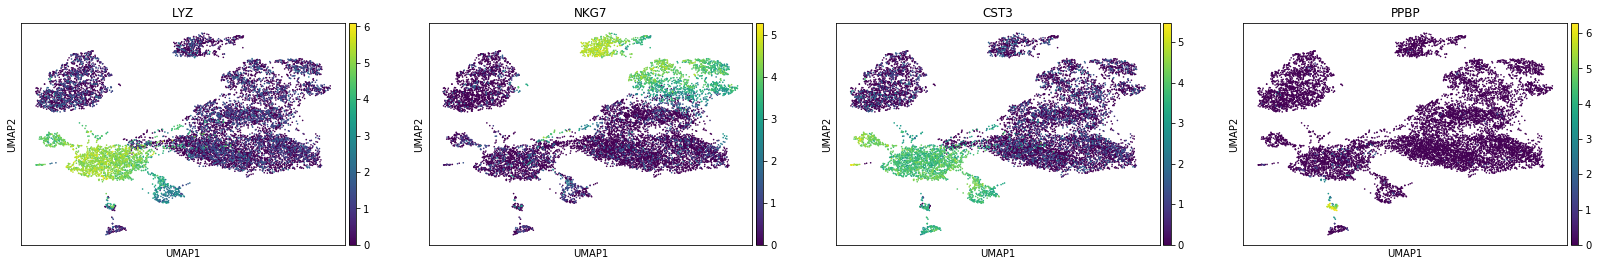

In [187]:
sc.pl.umap(adata, color=['LYZ', 'NKG7', 'CST3', 'PPBP'])

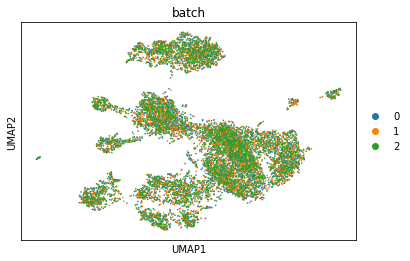

In [184]:
sc.pl.umap(adata, color='batch')